In [1]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

import pickle
import scipy

from ast import literal_eval

import seaborn as sns

from SGanalysis.SGobject import SGobject
from adjustText import adjust_text

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

# import matplotlib as mpl
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

plt.rcParams['font.size'] = 6  # Set default font size for all text elements
plt.rcParams['axes.labelsize'] = 8  # Set font size for axis labels
plt.rcParams['xtick.labelsize'] = 6  # Set font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 6  # Set font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 6  # Set font size for legend text

from sklearn.cluster import AgglomerativeClustering as AggCluster

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
import os

# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/analysis/tools/tools.py'
tools_path = '../helperScripts/tools.py'
# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py'

# /Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

In [2]:
## load data for the roi of interest    
roi_of_interest = 'roi_2'

# load the sg_object
with open(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/sg_object_dilate10_20240718.pkl', 'rb') as f:
    sg_obj = pickle.load(f)

# load the dataframes with the cell by gene matrices, clustered and unclustered
unclustered_df =  pd.read_csv(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_atleast3.csv')
clustered_df = pd.read_csv(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_clustering_10bcs_0.4thresh.csv')



In [3]:
# merge the clustered and unclustered dataframes
cols_to_keep = ['object_id','bc_cluster','bc_cluster_n_bcs','bc_cluster_found_bcs','bc_cluster_bc_names']
df = unclustered_df.merge(clustered_df[cols_to_keep],on='object_id',how='left')   

In [4]:
df['cell_id'] = [str(id) for id in df['object_id']]

# sg_obj.gdf['cell_id'] = [str(x) for x in sg_obj.gdf['object_id']]
sg_obj.gdf['object_id'] = sg_obj.gdf.index
sg_obj.gdf['cell_id'] = sg_obj.gdf['object_id'].astype('string')
sg_obj.gdf.index.name = 'index'
sg_obj.gdf = sg_obj.gdf.sort_values('object_id')

# assign clusters to the sg_obj
sg_obj.gdf = sg_obj.gdf.merge(df[['cell_id']+list(df.columns.difference(sg_obj.gdf.columns))],on=['cell_id'],how='left')

In [5]:
merged_gdf = sg_obj.gdf

In [6]:
gene_cols = [col for col in df.columns if 'bc_' not in col and col not in ['cell_id','object_id','area','called_barcodes','n_called_barcodes','barcode_names','area','center_x','center_y','nucleus','nucleus_centroid','nucleus_dilated']]    

adata_genes = sc.AnnData(df[gene_cols])

obs_cols= ['cell_id','n_called_barcodes','barcode_names','called_barcodes'] + cols_to_keep 

adata_genes.obs = df[obs_cols]

adata_genes.obs.index = [str(x) for x in adata_genes.obs.index]

/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_35770/749676134.py:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_genes = sc.AnnData(df[gene_cols])
/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [7]:
sg_obj.gdf

,nucleus,nucleus_dilated,nucleus_centroid,center_x,center_y,area,object_id,cell_id,AKT1,AXL,...,bc_093,bc_094,bc_095,bc_096,bc_cluster,bc_cluster_bc_names,bc_cluster_found_bcs,bc_cluster_n_bcs,called_barcodes,n_called_barcodes
0,"POLYGON ((23727.000 1097.000, 23741.000 1098.0...","POLYGON ((23723.193 1087.753, 23706.193 1094.7...",POINT (23747.880 1155.889),23747.879606,1155.889230,12083.909039,1,1,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,[],0.0
1,"POLYGON ((19439.000 1568.000, 19452.000 1569.0...","POLYGON ((19435.376 1558.680, 19417.376 1565.6...",POINT (19439.587 1590.119),19439.586687,1590.118851,3910.173214,10,10,1.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,"['bc_013', 'bc_060']",2.0
2,"POLYGON ((20345.000 1807.000, 20355.000 1818.0...","POLYGON ((20339.700 1798.520, 20333.649 1802.3...",POINT (20308.018 1845.079),20308.017937,1845.078634,6478.832120,100,100,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,[],0.0
3,"POLYGON ((10876.000 2957.000, 10910.000 2999.0...","POLYGON ((10866.161 2955.211, 10864.921 2962.0...",POINT (10900.868 3028.338),10900.868011,3028.338325,11563.956381,1000,1000,5.0,0.0,...,0.0,0.0,0.0,0.0,454.0,bc_068-bc_086,"['bc_068', 'bc_086']",2.0,"['bc_068', 'bc_086']",2.0
4,"POLYGON ((34221.000 9631.000, 34230.000 9631.0...","POLYGON ((34216.771 9621.938, 34201.771 9628.9...",POINT (34222.068 9672.302),34222.068445,9672.302458,8075.173801,10000,10000,0.0,0.0,...,0.0,2.0,0.0,0.0,615.0,bc_004-bc_033,"['bc_004', 'bc_033']",2.0,"['bc_004', 'bc_033']",2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67197,"POLYGON ((24154.000 9628.000, 24163.000 9628.0...","POLYGON ((24146.000 9622.000, 24140.000 9630.0...",POINT (24164.804 9654.365),24164.804188,9654.364679,2947.987326,9995,9995,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,[],0.0
67198,"POLYGON ((5129.000 9629.000, 5144.000 9639.000...","POLYGON ((5121.929 9621.929, 5120.807 9623.051...",POINT (5137.538 9667.617),5137.538337,9667.616848,5874.912824,9996,9996,2.0,0.0,...,0.0,0.0,0.0,0.0,2722.0,bc_005-bc_030,"['bc_005', 'bc_030']",2.0,"['bc_005', 'bc_030']",2.0
67199,"POLYGON ((10140.000 9629.000, 10161.000 9631.0...","POLYGON ((10135.862 9619.896, 10124.862 9624.8...",POINT (10145.028 9672.194),10145.027695,9672.194417,7313.562537,9997,9997,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67200,"POLYGON ((13878.000 9629.000, 13901.000 9632.0...","POLYGON ((13871.753 9621.191, 13866.753 9625.1...",POINT (13913.353 9668.934),13913.352589,9668.934064,8293.379014,9998,9998,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,[],0.0


In [8]:
adata_genes.obs

,cell_id,n_called_barcodes,barcode_names,called_barcodes,object_id,bc_cluster,bc_cluster_n_bcs,bc_cluster_found_bcs,bc_cluster_bc_names
0,1,0,NaN,[],1,NaN,NaN,NaN,NaN
1,10,2,bc_013-bc_060,"['bc_013', 'bc_060']",10,NaN,NaN,NaN,NaN
2,100,0,NaN,[],100,NaN,NaN,NaN,NaN
3,1000,2,bc_068-bc_086,"['bc_068', 'bc_086']",1000,454.0,2.0,"['bc_068', 'bc_086']",bc_068-bc_086
4,10000,2,bc_004-bc_033,"['bc_004', 'bc_033']",10000,615.0,2.0,"['bc_004', 'bc_033']",bc_004-bc_033
...,...,...,...,...,...,...,...,...,...
64531,9994,0,NaN,[],9994,NaN,NaN,NaN,NaN
64532,9995,0,NaN,[],9995,NaN,NaN,NaN,NaN
64533,9996,2,bc_005-bc_030,"['bc_005', 'bc_030']",9996,2722.0,2.0,"['bc_005', 'bc_030']",bc_005-bc_030
64534,9998,0,NaN,[],9998,NaN,NaN,NaN,NaN


Metrics based on filtering by 10 cells per cluster alone
Average cells per cluster 9.09375
Total cells here: 24893 24893/67202 (37.04%)
Number of clusters 327 327/3424 (9.55%)
Metrics based on filtering by 3 barcodes per cluster
Average cells per cluster 11.1
Total cells here: 14208 14208/67202 (21.14%)
Number of clusters 1280
Metrics based on additionally filtering by 10 cells per cluster
Average cells per cluster 78.46308724832215
Total cells here: 11691 11691/67202 (17.40%)
Number of clusters 149


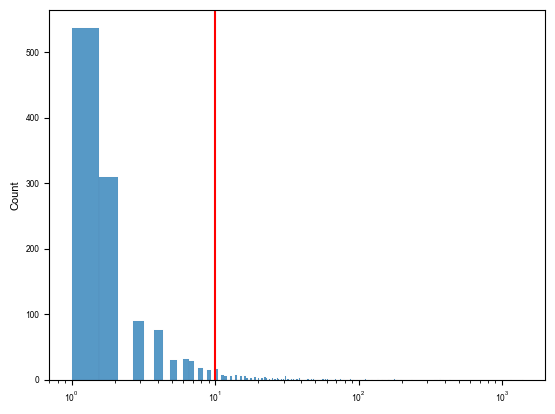

In [9]:
# n_bcs_per_cluster_cutoff = 3
# # n_cells_per_cluster_cutoff = 5
# n_cells_per_cluster_cutoff = 10

# # using the clustering to call clones
# confident_clusters = adata_genes[adata_genes.obs['bc_cluster_n_bcs'] >= n_bcs_per_cluster_cutoff]

# cluster_names, cluster_sizes = np.unique(confident_clusters.obs['bc_cluster'],return_counts=True)

# print(f'Metrics based on filtering by {n_bcs_per_cluster_cutoff} barcodes per cluster')
# print('Average cells per cluster',np.mean(cluster_sizes))
# print('Number of clusters',len(cluster_names))

# sns.histplot(cluster_sizes)
# plt.axvline(n_cells_per_cluster_cutoff,color='r')
# plt.xscale('log')

# # large enough clusters
# large_clusters = cluster_names[cluster_sizes >= n_cells_per_cluster_cutoff]

# confident_clusters = adata_genes[adata_genes.obs['bc_cluster'].isin(large_clusters)]

# cluster_names, cluster_sizes = np.unique(confident_clusters.obs['bc_cluster'],return_counts=True)
# # sns.histplot(cluster_sizes)

# print(f'Metrics based on additionally filtering by {n_cells_per_cluster_cutoff} cells per cluster')
# print('Average cells per cluster',np.mean(cluster_sizes))
# print('Number of clusters',len(cluster_names))


### FILTERING CLONES DOWN TO THOSE WITH MANY BARCODES AND/OR MANY CELLS

n_bcs_per_cluster_cutoff = 3
n_cells_per_cluster_cutoff = 10


## first get a GDF that's just those with at least 10 cells
cluster_sizes = adata_genes.obs.groupby('bc_cluster').size()
large_clusters = cluster_sizes[cluster_sizes >= n_cells_per_cluster_cutoff ].index.tolist()

large_clusters_gdf = sg_obj.gdf[sg_obj.gdf['bc_cluster'].isin(large_clusters)]

print(f'Metrics based on filtering by {n_cells_per_cluster_cutoff} cells per cluster alone')
print('Average cells per cluster',np.mean(cluster_sizes))
print('Total cells here:',len(large_clusters_gdf),f'{len(large_clusters_gdf)}/{len(sg_obj.gdf)} ({len(large_clusters_gdf)/len(sg_obj.gdf)*100:.2f}%)')
print('Number of clusters',len(large_clusters_gdf['bc_cluster'].unique()),f"{len(large_clusters_gdf['bc_cluster'].unique())}/{len(cluster_sizes)} ({len(large_clusters_gdf['bc_cluster'].unique())/len(cluster_sizes)*100:.2f}%)")

## now, let's look at onces with at least 10 cells and 3 barcodes per clone.
confident_clusters = adata_genes[adata_genes.obs['bc_cluster_n_bcs'] >= n_bcs_per_cluster_cutoff]

cluster_names, cluster_sizes = np.unique(confident_clusters.obs['bc_cluster'],return_counts=True)

print(f'Metrics based on filtering by {n_bcs_per_cluster_cutoff} barcodes per cluster')
print('Average cells per cluster',np.mean(cluster_sizes))
print('Total cells here:',len(confident_clusters),f'{len(confident_clusters)}/{len(sg_obj.gdf)} ({len(confident_clusters)/len(sg_obj.gdf)*100:.2f}%)')
print('Number of clusters',len(cluster_names))

sns.histplot(cluster_sizes)
plt.axvline(n_cells_per_cluster_cutoff,color='r')
plt.xscale('log')

# large enough clusters
large_clusters = cluster_names[cluster_sizes >= n_cells_per_cluster_cutoff]

confident_clusters = adata_genes[adata_genes.obs['bc_cluster'].isin(large_clusters)]

cluster_names, cluster_sizes = np.unique(confident_clusters.obs['bc_cluster'],return_counts=True)
# sns.histplot(cluster_sizes)

print(f'Metrics based on additionally filtering by {n_cells_per_cluster_cutoff} cells per cluster')
print('Average cells per cluster',np.mean(cluster_sizes))
print('Total cells here:',len(confident_clusters),f'{len(confident_clusters)}/{len(sg_obj.gdf)} ({len(confident_clusters)/len(sg_obj.gdf)*100:.2f}%)')
print('Number of clusters',len(cluster_names))

confident_clusters_gdf = sg_obj.gdf[sg_obj.gdf['bc_cluster'].isin(confident_clusters.obs['bc_cluster'].values)]






In [10]:
np.unique(confident_clusters.obs['bc_cluster'].values)

array([   8.,   10.,   15.,   16.,   20.,   21.,   28.,   31.,   35.,
         41.,   42.,   47.,   49.,   51.,   62.,   71.,   72.,   78.,
         83.,   93.,   98.,  102.,  106.,  109.,  112.,  121.,  138.,
        146.,  157.,  165.,  167.,  170.,  173.,  175.,  177.,  189.,
        195.,  196.,  201.,  203.,  204.,  207.,  214.,  218.,  222.,
        225.,  233.,  237.,  238.,  247.,  253.,  259.,  266.,  268.,
        270.,  274.,  284.,  288.,  299.,  308.,  309.,  318.,  319.,
        323.,  332.,  338.,  339.,  342.,  345.,  349.,  369.,  372.,
        374.,  391.,  394.,  400.,  404.,  406.,  411.,  420.,  431.,
        446.,  465.,  472.,  478.,  490.,  511.,  514.,  527.,  537.,
        548.,  553.,  557.,  564.,  614.,  622.,  630.,  638.,  644.,
        652.,  672.,  680.,  681.,  691.,  720.,  722.,  741.,  756.,
        762.,  764.,  783.,  794.,  826.,  831.,  845.,  846.,  848.,
        867.,  909.,  910.,  919.,  995., 1111., 1136., 1190., 1225.,
       1228., 1298.,

In [11]:
confident_clusters_gdf = sg_obj.gdf[sg_obj.gdf['bc_cluster'].isin(confident_clusters.obs['bc_cluster'].values)]

In [12]:
confident_clusters_gdf

,nucleus,nucleus_dilated,nucleus_centroid,center_x,center_y,area,object_id,cell_id,AKT1,AXL,...,bc_093,bc_094,bc_095,bc_096,bc_cluster,bc_cluster_bc_names,bc_cluster_found_bcs,bc_cluster_n_bcs,called_barcodes,n_called_barcodes
6,"POLYGON ((33928.000 9633.000, 33942.000 9635.0...","POLYGON ((33924.838 9623.513, 33915.838 9626.5...",POINT (33945.759 9675.416),33945.759162,9675.415681,8488.228745,10002,10002,0.0,0.0,...,0.0,9.0,0.0,0.0,845.0,bc_002-bc_004-bc_094,"['bc_002', 'bc_004', 'bc_094']",3.0,"['bc_002', 'bc_004', 'bc_094']",3.0
11,"POLYGON ((35965.000 9635.000, 35993.000 9637.0...","POLYGON ((35888.038 9755.805, 35889.191 9757.2...",POINT (35971.499 9701.483),35971.498673,9701.483157,18641.260537,10007,10007,2.0,0.0,...,0.0,0.0,0.0,0.0,548.0,bc_009-bc_014-bc_021,"['bc_009', 'bc_014', 'bc_021']",3.0,"['bc_009', 'bc_014', 'bc_019', 'bc_021']",4.0
14,"POLYGON ((12996.000 2958.000, 13010.000 2959.0...","POLYGON ((12979.064 3029.186, 12979.333 3029.4...",POINT (13001.707 2992.839),13001.706631,2992.839302,6153.822805,1001,1001,2.0,0.0,...,0.0,0.0,0.0,0.0,537.0,bc_001-bc_025-bc_030,"['bc_001', 'bc_025', 'bc_030']",3.0,"['bc_001', 'bc_025', 'bc_030']",3.0
18,"POLYGON ((19185.000 9637.000, 19201.000 9638.0...","POLYGON ((19181.390 9627.674, 19150.390 9639.6...",POINT (19188.053 9702.727),19188.053031,9702.727225,14807.975005,10013,10013,3.0,0.0,...,0.0,0.0,16.0,0.0,1190.0,bc_003-bc_076-bc_095,"['bc_003', 'bc_076', 'bc_095']",3.0,"['bc_003', 'bc_076', 'bc_095']",3.0
20,"POLYGON ((30631.000 9638.000, 30646.000 9640.0...","POLYGON ((30558.529 9732.873, 30562.700 9735.4...",POINT (30615.295 9688.707),30615.294706,9688.706524,11836.997397,10015,10015,0.0,0.0,...,0.0,0.0,0.0,0.0,138.0,bc_025-bc_047-bc_058-bc_076-bc_079,"['bc_025', 'bc_047', 'bc_058', 'bc_076', 'bc_0...",5.0,"['bc_025', 'bc_040', 'bc_047', 'bc_059', 'bc_0...",6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67176,"POLYGON ((19349.000 9618.000, 19360.000 9618.0...","POLYGON ((19348.445 9608.015, 19330.445 9609.0...",POINT (19329.817 9668.821),19329.817473,9668.821226,12284.464291,9976,9976,0.0,0.0,...,0.0,0.0,13.0,0.0,1190.0,bc_003-bc_076-bc_095,"['bc_003', 'bc_076', 'bc_095']",3.0,"['bc_003', 'bc_013', 'bc_076', 'bc_095']",4.0
67180,"POLYGON ((15698.000 2956.000, 15711.000 2956.0...","POLYGON ((15694.061 2946.809, 15680.061 2952.8...",POINT (15702.937 2988.794),15702.936864,2988.793734,5499.612463,998,998,1.0,0.0,...,0.0,0.0,0.0,0.0,2386.0,bc_025-bc_060-bc_062-bc_066,"['bc_025', 'bc_060', 'bc_062', 'bc_066']",4.0,"['bc_025', 'bc_060', 'bc_062', 'bc_066']",4.0
67187,"POLYGON ((30315.000 9623.000, 30332.000 9623.0...","POLYGON ((30288.075 9719.483, 30288.338 9719.9...",POINT (30351.533 9684.110),30351.533431,9684.109860,18563.854953,9986,9986,1.0,0.0,...,0.0,0.0,0.0,0.0,138.0,bc_025-bc_047-bc_058-bc_076-bc_079,"['bc_025', 'bc_047', 'bc_058', 'bc_076', 'bc_0...",5.0,"['bc_025', 'bc_039', 'bc_047', 'bc_058', 'bc_0...",8.0
67189,"POLYGON ((36956.000 9625.000, 36976.000 9626.0...","POLYGON ((36941.576 9622.135, 36941.294 9622.0...",POINT (36965.342 9653.127),36965.342480,9653.126698,5465.866622,9988,9988,2.0,0.0,...,0.0,0.0,0.0,0.0,548.0,bc_009-bc_014-bc_021,"['bc_009', 'bc_014', 'bc_021']",3.0,"['bc_009', 'bc_014']",2.0


In [13]:
### We can look at which clusters have the highest SFRP1 expression. Cluster 31 has the hightest.

confident_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].mean().sort_values(ascending=False).head(10)

bc_cluster
31.0      3.379310
490.0     1.454545
41.0      0.692308
1136.0    0.571429
391.0     0.557377
253.0     0.529412
51.0      0.500000
909.0     0.454545
1298.0    0.444444
49.0      0.404255
Name: SFRP1, dtype: float64

In [14]:
## When we plotted Cluster 31, we noticed there were many neighboring cells that also expressed SFRP1. 
## We further manually annotated the cells in the neighborhood to ensure cells were correctly assigned to the cluster.

manual_annotation = pd.read_csv('../extractedData/in_vivo/cluster 31 manual annotation - manual_annotation_radius_large.csv')

manual_annotation= manual_annotation[manual_annotation['object_id'].notnull()]


In [15]:
manual_cluster = manual_annotation[((manual_annotation['FIRST_PASS_CONTAINS_BARCODES'].isin(['POSSIBLE','TRUE']) & 
                   manual_annotation['SECOND_PASS_CONTAINS_NO_EXTRA_BARCODES'].isin(['TRUE']))) |

                   ((manual_annotation['FIRST_PASS_CONTAINS_BARCODES'].isin(['TRUE']) & 
                   manual_annotation['SECOND_PASS_CONTAINS_NO_EXTRA_BARCODES'].isin(['POSSIBLE','TRUE']))) | 
                   
                   ((manual_annotation['FIRST_PASS_CONTAINS_BARCODES'].isin(['POSSIBLE']) & 
                   manual_annotation['SECOND_PASS_CONTAINS_NO_EXTRA_BARCODES'].isin(['POSSIBLE']))) 

                   ] 
                   

In [16]:
sg_obj.gdf

,nucleus,nucleus_dilated,nucleus_centroid,center_x,center_y,area,object_id,cell_id,AKT1,AXL,...,bc_093,bc_094,bc_095,bc_096,bc_cluster,bc_cluster_bc_names,bc_cluster_found_bcs,bc_cluster_n_bcs,called_barcodes,n_called_barcodes
0,"POLYGON ((23727.000 1097.000, 23741.000 1098.0...","POLYGON ((23723.193 1087.753, 23706.193 1094.7...",POINT (23747.880 1155.889),23747.879606,1155.889230,12083.909039,1,1,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,[],0.0
1,"POLYGON ((19439.000 1568.000, 19452.000 1569.0...","POLYGON ((19435.376 1558.680, 19417.376 1565.6...",POINT (19439.587 1590.119),19439.586687,1590.118851,3910.173214,10,10,1.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,"['bc_013', 'bc_060']",2.0
2,"POLYGON ((20345.000 1807.000, 20355.000 1818.0...","POLYGON ((20339.700 1798.520, 20333.649 1802.3...",POINT (20308.018 1845.079),20308.017937,1845.078634,6478.832120,100,100,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,[],0.0
3,"POLYGON ((10876.000 2957.000, 10910.000 2999.0...","POLYGON ((10866.161 2955.211, 10864.921 2962.0...",POINT (10900.868 3028.338),10900.868011,3028.338325,11563.956381,1000,1000,5.0,0.0,...,0.0,0.0,0.0,0.0,454.0,bc_068-bc_086,"['bc_068', 'bc_086']",2.0,"['bc_068', 'bc_086']",2.0
4,"POLYGON ((34221.000 9631.000, 34230.000 9631.0...","POLYGON ((34216.771 9621.938, 34201.771 9628.9...",POINT (34222.068 9672.302),34222.068445,9672.302458,8075.173801,10000,10000,0.0,0.0,...,0.0,2.0,0.0,0.0,615.0,bc_004-bc_033,"['bc_004', 'bc_033']",2.0,"['bc_004', 'bc_033']",2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67197,"POLYGON ((24154.000 9628.000, 24163.000 9628.0...","POLYGON ((24146.000 9622.000, 24140.000 9630.0...",POINT (24164.804 9654.365),24164.804188,9654.364679,2947.987326,9995,9995,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,[],0.0
67198,"POLYGON ((5129.000 9629.000, 5144.000 9639.000...","POLYGON ((5121.929 9621.929, 5120.807 9623.051...",POINT (5137.538 9667.617),5137.538337,9667.616848,5874.912824,9996,9996,2.0,0.0,...,0.0,0.0,0.0,0.0,2722.0,bc_005-bc_030,"['bc_005', 'bc_030']",2.0,"['bc_005', 'bc_030']",2.0
67199,"POLYGON ((10140.000 9629.000, 10161.000 9631.0...","POLYGON ((10135.862 9619.896, 10124.862 9624.8...",POINT (10145.028 9672.194),10145.027695,9672.194417,7313.562537,9997,9997,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67200,"POLYGON ((13878.000 9629.000, 13901.000 9632.0...","POLYGON ((13871.753 9621.191, 13866.753 9625.1...",POINT (13913.353 9668.934),13913.352589,9668.934064,8293.379014,9998,9998,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,[],0.0


In [17]:
sg_obj.assigned_points_gdf

,name,refid,x,y,geometry,index_right,object_id,nucleus,distance_to_edge
3055875,CDK1,ENSG00000170312,50998,31118,POINT (50998.000 31118.000),44496.0,43996,"POLYGON ((50966.000 30944.000, 50976.000 30946...",123.685566
11908488,CCND1,ENSG00000110092,51009,31126,POINT (51009.000 31126.000),44496.0,43996,"POLYGON ((50966.000 30944.000, 50976.000 30946...",115.551054
11908492,CCND1,ENSG00000110092,50996,31167,POINT (50996.000 31167.000),44496.0,43996,"POLYGON ((50966.000 30944.000, 50976.000 30946...",115.115687
16545015,COL5A2,ENSG00000204262,51006,31150,POINT (51006.000 31150.000),44496.0,43996,"POLYGON ((50966.000 30944.000, 50976.000 30946...",113.741371
13013973,SPARC,ENSG00000113140,50997,31169,POINT (50997.000 31169.000),44496.0,43996,"POLYGON ((50966.000 30944.000, 50976.000 30946...",113.174236
...,...,...,...,...,...,...,...,...,...
16584996,ENSMUSG00000071361,ENSMUSG00000071361,9197,48023,POINT (9197.000 48023.000),NaN,NaN,None,NaN
16584997,ENSMUSG00000071361,ENSMUSG00000071361,9245,47972,POINT (9245.000 47972.000),NaN,NaN,None,NaN
16584998,ENSMUSG00000071361,ENSMUSG00000071361,10479,47915,POINT (10479.000 47915.000),NaN,NaN,None,NaN
16584999,ENSMUSG00000071361,ENSMUSG00000071361,42879,47872,POINT (42879.000 47872.000),NaN,NaN,None,NaN


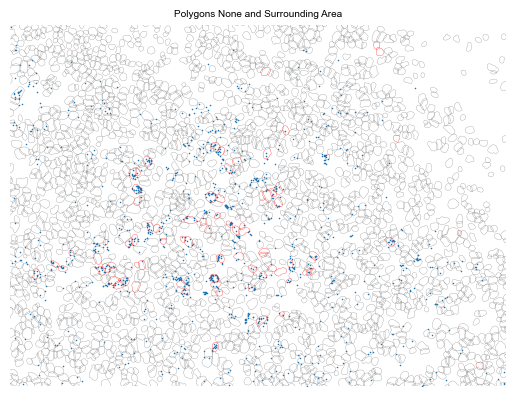

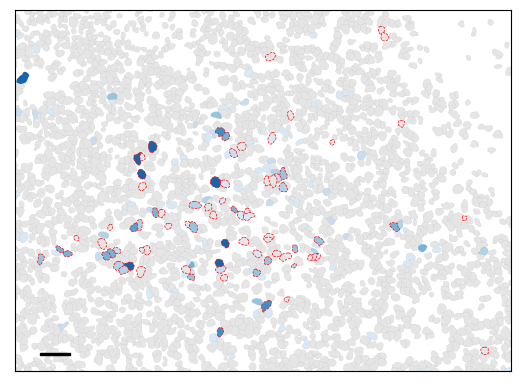

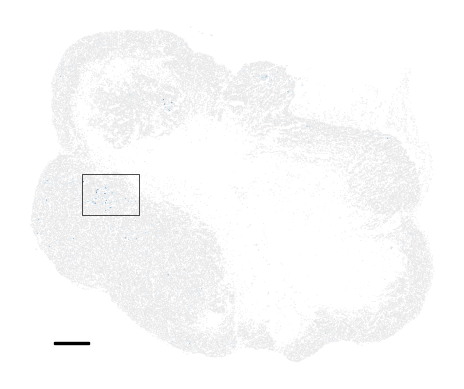

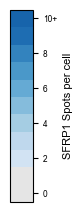

In [18]:
gene_of_interest = 'SFRP1'
cluster_of_interest = 31
# get the cells associated with the manual cluster
cluster_cells = list(adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])].obs['cell_id'].values)

# cluster_of_interest = [490]
# cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster'].isin([cluster_of_interest])].obs['cell_id'].values)

central_ix = int(len(cluster_cells)/2) 
cell_id = cluster_cells[central_ix] # get the cell in the middle of the cluster, we'll center on that one

region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=1,id_field='cell_id')

fig,ax = plt.subplots()
tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=['SFRP1'],central_polygon_ix=central_ix,
                            color_map={'SFRP1':(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)},
                            #    id_field='cell_id',
                            annotate=False,image_scale=0.1,
                            focal_outline_color='r',other_outline_color='gray',
                            interior_marker='.',single_mode=False,lw=0.2,
                            exterior_marker='.',marker_size=5,ax=ax)

ymin,ymax = plt.ylim()
xmin,xmax = plt.xlim()

plt.axis('off')
# plt.title()
plt.gca().invert_yaxis()

### PLOT THE ZOOMED IN IMAGE     
fig,ax = plt.subplots()

vmin = 2
vmax = 10

norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

bbox = box(xmin,ymin,xmax,ymax)
other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

merged_gdf_other = merged_gdf[merged_gdf['cell_id'].isin(other_clusters['cell_id'].values)]

cmap = matplotlib.cm.get_cmap('Blues').copy()
cmap = cmap(np.linspace(0.15, 0.8, 256))

cmap = matplotlib.colors.ListedColormap(cmap)
cmap.set_under('#e5e5e5') # set low values to gray

merged_gdf_other.plot(column=gene_of_interest, cmap=cmap, legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='gray',linewidth=0.05)

# this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest]
this_cluster = adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])]

merged_gdf_focal = merged_gdf[merged_gdf['cell_id'].isin(this_cluster.obs['cell_id'].values)]

# print(merged_gdf_focal.shape)
merged_gdf_focal.plot(column=gene_of_interest, cmap=cmap, legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='r',linewidth=0.5,linestyle='--')

# Add the patch to the Axes
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.gca().invert_yaxis()

# xmin,xmax = plt.xlim()
# ymin,ymax = plt.ylim()  

scale_bar_length_um = 50 # 1000um scale bar
scale_bar_length_px = int(scale_bar_length_um * 1000.0 / tools.sg_pixel_size)  # px
scale_bar = matplotlib.patches.Rectangle((xmin+(0.05*((xmax-xmin))),ymax-(0.05*(ymax-ymin))), 
                                          scale_bar_length_px, scale_bar_length_px/20, linewidth=1, edgecolor='k', facecolor='k')
plt.gca().add_patch(scale_bar)

ax.set_xticks([])
ax.set_yticks([])
# ax.set_facecolor('#F5F5F5')
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_zoom_grayed.pdf',bbox_inches='tight')


### PLOT THE FULL IMAGE WITH THE CLUSTER HIGHLIGHTED
fig,ax = plt.subplots()

merged_gdf.plot(column=gene_of_interest, cmap=cmap, legend=False,vmin=vmin,vmax=vmax,ax=ax,
                edgecolor='#d9d9d9',linewidth=0.0)

# rectangle where magnification is
rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=0.5, edgecolor='k', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

ax.set_facecolor('#F5F5F5')


xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()  

scale_bar_length_um = 500 # 1000um scale bar
scale_bar_length_px = int(scale_bar_length_um * 1000.0 / tools.sg_pixel_size)  # px
scale_bar = matplotlib.patches.Rectangle((xmin+(0.1*((xmax-xmin))),ymax-(0.1*(ymax-ymin))), 
                                          scale_bar_length_px, scale_bar_length_px/20, linewidth=1, edgecolor='k', facecolor='k')
plt.gca().add_patch(scale_bar)

plt.axis('off')
plt.gca().invert_yaxis()

plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_full_grayed.pdf',bbox_inches='tight',transparent=True)
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_full_grayed.png',dpi=500,bbox_inches='tight',transparent=True)


### PLOT THE COLORBAR
fig,ax = plt.subplots(figsize=(0.3,2.5))
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax,clip=False)
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,boundaries=[0]+list(np.arange(1,12,1)),ticks=[0,2,4,6,8,10],
                            norm=norm,
                            orientation='vertical')
cb1.set_label('SFRP1 Spots per cell')

cb1.set_ticks([x+0.5 for x in [0,2,4,6,8,10]])
cb1.set_ticklabels(['0','2','4','6','8','10+'])

plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_colorbar_grayed.pdf',bbox_inches='tight',transparent=True)



In [19]:
from shapely.geometry import Point
from shapely.ops import unary_union
import geopandas as gpd

Entire Tumor
Mean SFRP1 epxression: 0.1041589190529317
Fraction of cells with SFRP1 > 1: 0.015712160654518408
number of cells total: 64536
number of cells with SFRP1 > 1: 1014
Neighbors
Mean SFRP1 expression: 0.17851170568561872
Fraction of cells with SFRP1 > 1: 0.0338628762541806
number of cells total: 2392
number of cells with SFRP1 > 1: 81
Neighbors (within 100um)
Mean SFRP1 expression: 1.705607476635514
Fraction of cells with SFRP1 > 1: 0.02717391304347826
number of cells total: 214
number of cells with SFRP1 > 1: 65
Ttest_indResult(statistic=4.310420556649, pvalue=2.2324702063225753e-05)
clone 31
Mean SFRP1 expression: 3.7468354430379747
Fraction of cells with SFRP1 > 1: 0.5822784810126582
number of cells total: 79
number of cells with SFRP1 > 1: 46


Text(0.5, 0, 'Proportion of cells in group (sorted)')

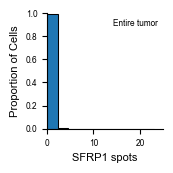

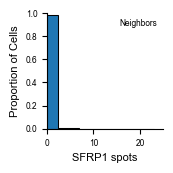

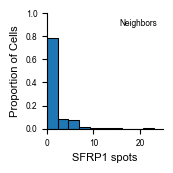

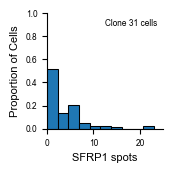

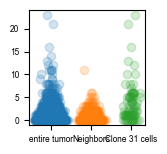

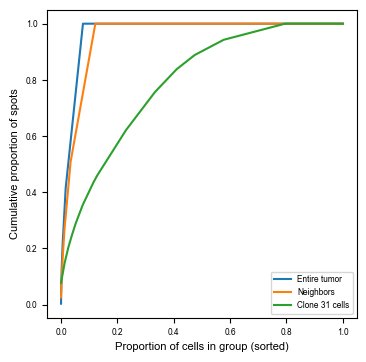

In [20]:
#### plot distributions of counts within the clone, compared to its neighborhood and the entire tumor 
# plt.subplots(figsize=(12,4),sharex=True,sharey=True)
# non_zero_cells = df[df['SFRP1']>1]
counts,bins = np.histogram(df['SFRP1'])

cluster_of_interest = 31

plt.figure(figsize=(1.5,1.5))
ax = plt.gca()
# entire tumor
# ax = plt.subplot(1,3,3)
plt.text(s='Entire tumor',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
# plt.title('Entire tumor')
sns.histplot(df['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlim(0,25)
plt.xlabel('SFRP1 spots')
plt.ylabel('Proportion of Cells')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_hists_full.pdf',bbox_inches='tight',transparent=True)

print('Entire Tumor')
print('Mean SFRP1 epxression:',df['SFRP1'].mean())
print('Fraction of cells with SFRP1 > 1:',np.sum(df['SFRP1']>1)/len(df))
print('number of cells total:',len(df))
print('number of cells with SFRP1 > 1:',np.sum(df['SFRP1']>1))

plt.figure(figsize=(1.5,1.5))
ax = plt.gca()
# neighbors
# ax = plt.subplot(1,3,2)
plt.text(s='Neighbors',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
# plt.title('Clone 31 neighboring cells')
sns.histplot(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlim(0,25)
plt.xlabel('SFRP1 spots')
plt.ylabel('Proportion of Cells')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_hists_neighbors.pdf',bbox_inches='tight',transparent=True)

print('Neighbors')
print('Mean SFRP1 expression:',df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]['SFRP1'].mean())
print('Fraction of cells with SFRP1 > 1:',np.sum(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]['SFRP1']>1)/len(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]))
print('number of cells total:',len(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]))
print('number of cells with SFRP1 > 1:',np.sum(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]['SFRP1']>1))


# gdf_within_region = sg_obj.gdf.cx[box_xlims[0]:box_xlims[1], box_ylims[0]:box_ylims[1]]
# regional_cells_only = gdf_within_region[~(gdf_within_region['cell_id'].isin(cluster_cells))]

# Convert distance from um to pixels
distance_um = 100  # 100um is roughly 5-10 cell lengths
distance_px = distance_um / tools.sg_pixel_size  # Simplified conversion

cluster_cells = merged_gdf[merged_gdf['cell_id'].isin([str(x) for x in manual_cluster['object_id']])]
# Using buffer and spatial join
# Create a buffer around all cluster cells
cluster_union = unary_union(cluster_cells.geometry)
buffer_zone = cluster_union.buffer(distance_px)
# Find all cells that intersect with the buffer zone
neighboring_cells = merged_gdf[merged_gdf.geometry.intersects(buffer_zone)]
# exclude the original cluster cells from the result
neighboring_cells_only = neighboring_cells[~neighboring_cells['object_id'].isin(manual_cluster['object_id'])]

plt.figure(figsize=(1.5,1.5))
ax = plt.gca()
# neighbors
# ax = plt.subplot(1,3,2)
plt.text(s='Neighbors',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
# plt.title('Clone 31 neighboring cells')
sns.histplot(df[df['object_id'].isin([int(x) for x in neighboring_cells_only['object_id']])]['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlim(0,25)
plt.xlabel('SFRP1 spots')
plt.ylabel('Proportion of Cells')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_hists_neighbors{distance_um}um.pdf',bbox_inches='tight',transparent=True)

print(f'Neighbors (within {distance_um}um)')
print('Mean SFRP1 expression:',df[df['object_id'].isin([int(x) for x in neighboring_cells_only['object_id']])]['SFRP1'].mean())
print('Fraction of cells with SFRP1 > 1:',np.sum(df[df['object_id'].isin([int(x) for x in neighboring_cells_only['object_id']])]['SFRP1']>1)/len(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]))
print('number of cells total:',len(df[df['object_id'].isin([int(x) for x in neighboring_cells_only['object_id']])]))
print('number of cells with SFRP1 > 1:',np.sum(df[df['object_id'].isin([int(x) for x in neighboring_cells_only['object_id']])]['SFRP1']>1))
# t-test
print(scipy.stats.ttest_ind(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'],df[df['object_id'].isin([int(x) for x in neighboring_cells_only['object_id']])]['SFRP1']))



plt.figure(figsize=(1.5,1.5))
ax = plt.gca()
# clone 31
# ax = plt.subplot(1,3,1)
plt.text(s='Clone 31 cells',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
sns.histplot(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlim(0,25)
plt.xlabel('SFRP1 spots')
plt.ylabel('Proportion of Cells')
ax.spines[['right', 'top']].set_visible(False)
# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_hists.pdf',bbox_inches='tight')
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_hists_clone31.pdf',bbox_inches='tight',transparent=True)

print('clone 31')
print('Mean SFRP1 expression:',df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'].mean())
print('Fraction of cells with SFRP1 > 1:',np.sum(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1']>1)/len(df[df['object_id'].isin(manual_cluster['object_id'])]))
print('number of cells total:',len(df[df['object_id'].isin(manual_cluster['object_id'])]))
print('number of cells with SFRP1 > 1:',np.sum(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1']>1))


fig,ax = plt.subplots(figsize=(1.5,1.5))

# entire tumor
ax.scatter([tools.jitter_point(0,0.1) for x in df['SFRP1']],
            df['SFRP1'],alpha=0.2)


# neighbors
neighbors = df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]
ax.scatter([tools.jitter_point(1,0.1) for x in neighbors['SFRP1']],
            neighbors['SFRP1'],alpha=0.2)

# clone 31
ax.scatter([tools.jitter_point(2,0.1) for x in df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1']],
            df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'],alpha=0.2)
# sns.histplot(,bins=bins,alpha=1.0,stat='proportion',ax=ax)

plt.xticks(range(3),['entire tumor','Neighbors','Clone 31 cells'])
# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_jitter.pdf',bbox_inches='tight')

fig,ax = plt.subplots(figsize=(4,4))
plt.plot(np.linspace(0,1,len(df['SFRP1'])),
         np.cumsum(df['SFRP1'].sort_values(ascending=False).values)/np.sum(df['SFRP1']),
         label='Entire tumor')
plt.plot(np.linspace(0,1,len(neighbors['SFRP1'])),
         np.cumsum(neighbors['SFRP1'].sort_values(ascending=False).values)/np.sum(neighbors['SFRP1']),
         label='Neighbors')
plt.plot(np.linspace(0,1,len(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'])),
         np.cumsum(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'].sort_values(ascending=False).values)/np.sum(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1']),
         label='Clone 31 cells')
plt.legend()

plt.ylabel('Cumulative proportion of spots')
plt.xlabel('Proportion of cells in group (sorted)')



In [21]:
# plot SFRP1 spots for the whole roi

# open spots file
spots_df = pd.read_csv(tools.roi_file_paths[roi_of_interest]["spots_file"])

<Figure size 640x480 with 0 Axes>

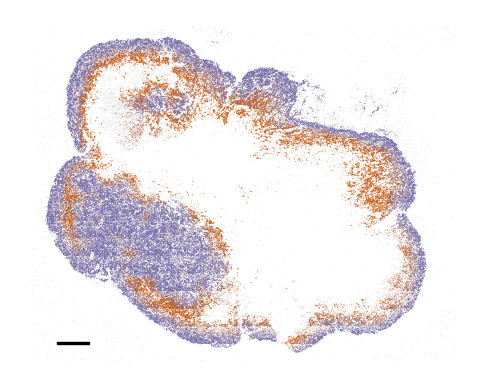

In [22]:
# plt.figure()
gene_of_interest = 'SFRP1'

gene_list = ['VEGFA',
             'MITF',
            #  'SPARC',
            'SFRP1',
                ]

gene_list = ['VEGFA',
             'MITF',
            #  'SPARC',
            # 'SFRP1',
                ]

gene_colors = {'VEGFA':'b',
               'MITF':'r',}

gene_colors = {
                # 'VEGFA':'#5e3c99',
               'VEGFA':'#d95f02',
               
            #    'MITF':'#e66101',
               'MITF':'#7570b3',
               
               }


plt.figure()
sg_obj.gdf.plot(color='gray',lw=0.01,alpha=0.1)

for gene_of_interest in gene_list:

    # get the spots for the gene of interest
    spots_gene = spots_df[spots_df['name']==gene_of_interest]

    plt.scatter(spots_gene['x'],spots_gene['y'],s=0.1,alpha=0.4,lw=0,color=gene_colors[gene_of_interest])

xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()  

scale_bar_length_um = 500 # 1000um scale bar
scale_bar_length_px = int(scale_bar_length_um * 1000.0 / tools.sg_pixel_size)  # px
scale_bar = matplotlib.patches.Rectangle((xmin+(0.1*((xmax-xmin))),ymax-(0.1*(ymax-ymin))), 
                                          scale_bar_length_px, scale_bar_length_px/20, linewidth=1, edgecolor='k', facecolor='k')
plt.gca().add_patch(scale_bar)

plt.axis('off')
# plt.title(gene_of_interest)
plt.gca().invert_yaxis()

plt.savefig(f'../graphs/space_VEGFA_MITF_full.pdf',bbox_inches='tight',transparent=True)
plt.savefig(f'../graphs/space_VEGFA_MITF_full.png',dpi=500,bbox_inches='tight',transparent=True)

    

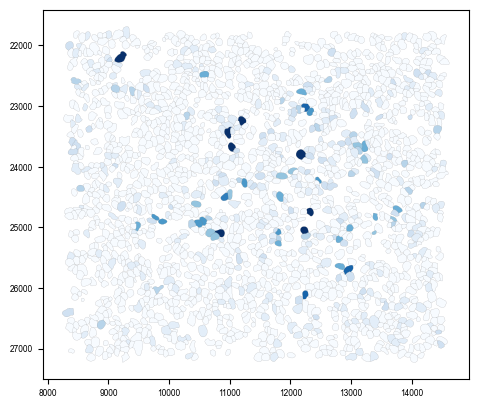

In [23]:
region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=55,id_field='cell_id')

fig,ax = plt.subplots()
region.plot('SFRP1',ax=ax,edgecolor='gray',lw=0.1,cmap='Blues',vmin=0,vmax=10)

# invert y axis
plt.gca().invert_yaxis()
# region.

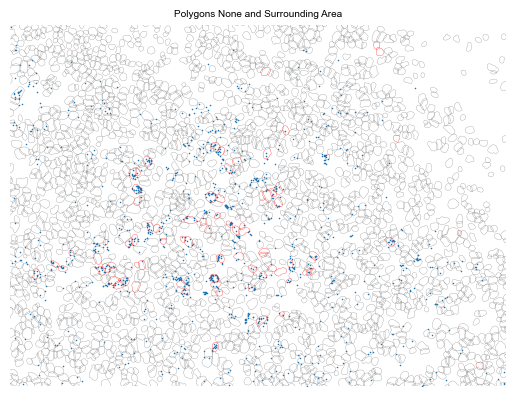

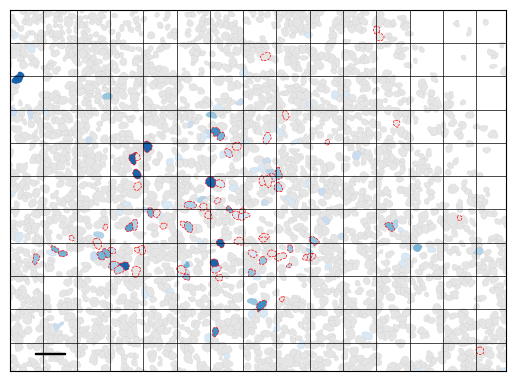

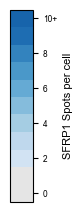

In [24]:
# comparision to grid-based spatial transcriptomics technologies

gene_of_interest = 'SFRP1'
cluster_of_interest = 31

# get the cells associated with the manual cluster
cluster_cells = list(adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])].obs['cell_id'].values)
central_ix = int(len(cluster_cells)/2) 
cell_id = cluster_cells[central_ix] # get the cell in the middle of the cluster, we'll center on that one

region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=55,id_field='cell_id')

fig,ax = plt.subplots()
tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=['SFRP1'],central_polygon_ix=central_ix,
                            color_map={'SFRP1':(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)},
                            #    id_field='cell_id',
                            annotate=False,image_scale=0.1,
                            focal_outline_color='r',other_outline_color='gray',
                            interior_marker='.',single_mode=False,lw=0.2,
                            exterior_marker='.',marker_size=5,ax=ax)

ymin,ymax = plt.ylim()
xmin,xmax = plt.xlim()

plt.axis('off')
# plt.title()
plt.gca().invert_yaxis()

### PLOT THE ZOOMED IN IMAGE     
fig,ax = plt.subplots()

vmin = 2
vmax = 10

norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

bbox = box(xmin,ymin,xmax,ymax)
other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

merged_gdf_other = merged_gdf[merged_gdf['cell_id'].isin(other_clusters['cell_id'].values)]

cmap = matplotlib.cm.get_cmap('Blues').copy()
cmap = cmap(np.linspace(0.15, 0.8, 256))

cmap = matplotlib.colors.ListedColormap(cmap)
cmap.set_under('#e5e5e5') # set low values to gray

merged_gdf_other.plot(column=gene_of_interest, cmap=cmap, legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='gray',linewidth=0.05)

# this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest]
this_cluster = adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])]

merged_gdf_focal = merged_gdf[merged_gdf['cell_id'].isin(this_cluster.obs['cell_id'].values)]

# print(merged_gdf_focal.shape)
merged_gdf_focal.plot(column=gene_of_interest, cmap=cmap, legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='r',linewidth=0.5,linestyle='--')

# visium HD has theoretical 2 micron grid size. This is roughly every 2000/107 = 18.7 pixels
# plt.gca().set_xticks([xmin+18.7*i for i in range(int((xmax-xmin)/18.7)+1)])
# plt.gca().set_yticks([ymin+18.7*i for i in range(int((ymax-ymin)/18.7)+1)])

# visium HD has 8 micron grid size as recommended resolution. This is roughly every 8000/107 =74.77 pixels
# plt.gca().set_xticks([xmin+74.77*i for i in range(int((xmax-xmin)/74.77)+1)])
# plt.gca().set_yticks([ymin+74.77*i for i in range(int((ymax-ymin)/74.77)+1)])

# visium has 55 micron grid size. This is roughly every 55000/107 = 514 pixels
plt.gca().set_xticks([xmin+514*i for i in range(int((xmax-xmin)/514)+1)])
plt.gca().set_yticks([ymin+514*i for i in range(int((ymax-ymin)/514)+1)])
plt.gca().tick_params(which='major', color='k',length=0)
plt.gca().grid(True, which='major',zorder=100,color='k',lw=0.5)

plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])

# plt.gca().tick_params()

ax.tick_params(axis='both', which='major', labelsize=5)
ax.tick_params(axis='both', which='minor', labelsize=2)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()  

scale_bar_length_um = 50 # 1000um scale bar
scale_bar_length_px = int(scale_bar_length_um * 1000.0 / tools.sg_pixel_size)  # px
scale_bar = matplotlib.patches.Rectangle((xmin+(0.05*((xmax-xmin))),ymax-(0.05*(ymax-ymin))), 
                                          scale_bar_length_px, scale_bar_length_px/20, linewidth=1, edgecolor='k', facecolor='k')
plt.gca().add_patch(scale_bar)


plt.gca().invert_yaxis()
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_zoom_grid.pdf',bbox_inches='tight')



### PLOT THE COLORBAR
fig,ax = plt.subplots(figsize=(0.3,2.5))
# cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap='Reds',
#                             norm=norm,
#                             orientation='vertical')
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax,clip=False)
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,boundaries=[0]+list(np.arange(1,12,1)),ticks=[0,2,4,6,8,10],
                            norm=norm,
                            orientation='vertical')
cb1.set_label('SFRP1 Spots per cell')

cb1.set_ticks([x+0.5 for x in [0,2,4,6,8,10]])
cb1.set_ticklabels(['0','2','4','6','8','10+'])
# ax.set_yticks([x+0.5 for x in [0,2,4,6,8,10]],[0,2,4,6,8,10])

# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_cb.pdf',bbox_inches='tight')
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_colorbar_grayed_grid.pdf',bbox_inches='tight',transparent=True)


# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_cb.pdf',bbox_inches='tight')



In [25]:
# gene_of_interest = 'SFRP1'
# cluster_of_interest = 31

# # get the cells associated with the manual cluster
# cluster_cells = list(adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])].obs['cell_id'].values)
# central_ix = int(len(cluster_cells)/2) 
# cell_id = cluster_cells[central_ix] # get the cell in the middle of the cluster, we'll center on that one

# region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=25,id_field='cell_id')

In [26]:
region

,nucleus,nucleus_dilated,nucleus_centroid,center_x,center_y,area,object_id,cell_id,AKT1,AXL,...,bc_093,bc_094,bc_095,bc_096,bc_cluster,bc_cluster_bc_names,bc_cluster_found_bcs,bc_cluster_n_bcs,called_barcodes,n_called_barcodes
20617,"POLYGON ((9300.000 21697.000, 9309.000 21697.0...","POLYGON ((9231.187 21767.767, 9230.905 21767.8...",POINT (9289.939 21790.083),9289.939260,21790.082829,20549.431504,28554,28554,3.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,[],0.0
20708,"POLYGON ((9165.000 21754.000, 9183.000 21754.0...","POLYGON ((9163.233 21744.157, 9124.233 21751.1...",POINT (9152.922 21821.188),9152.921736,21821.188314,21308.893773,28636,28636,4.0,0.0,...,0.0,0.0,0.0,0.0,120.0,bc_022,['bc_022'],1.0,['bc_022'],1.0
20720,"POLYGON ((10184.000 21760.000, 10199.000 21761...","POLYGON ((10179.144 21751.258, 10173.357 21754...",POINT (10199.804 21818.950),10199.804015,21818.949948,15142.717553,28647,28647,2.0,0.0,...,0.0,0.0,0.0,0.0,204.0,bc_001-bc_004-bc_031-bc_041-bc_087,"['bc_001', 'bc_004', 'bc_031', 'bc_041', 'bc_0...",5.0,"['bc_001', 'bc_004', 'bc_024', 'bc_041', 'bc_0...",5.0
20732,"POLYGON ((8485.000 21767.000, 8496.000 21768.0...","POLYGON ((8482.751 21757.256, 8469.751 21760.2...",POINT (8465.846 21817.262),8465.846433,21817.261566,9026.820799,28658,28658,0.0,0.0,...,0.0,0.0,0.0,0.0,1443.0,bc_006-bc_010-bc_066,"['bc_006', 'bc_010', 'bc_066']",3.0,"['bc_006', 'bc_066']",2.0
20737,"POLYGON ((9010.000 21768.000, 9023.000 21770.0...","POLYGON ((9008.356 21758.136, 8984.356 21762.1...",POINT (9002.734 21820.932),9002.734256,21820.931674,11191.158372,28662,28662,6.0,0.0,...,0.0,0.0,0.0,0.0,909.0,bc_010-bc_022-bc_066,"['bc_010', 'bc_022', 'bc_066']",3.0,"['bc_010', 'bc_022', 'bc_066']",3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,"POLYGON ((10423.000 27085.000, 10439.000 27086...","POLYGON ((10382.259 27187.217, 10382.322 27187...",POINT (10427.455 27138.044),10427.455151,27138.043773,9680.784918,37133,37133,8.0,2.0,...,0.0,0.0,0.0,0.0,919.0,bc_004-bc_041-bc_048-bc_060,"['bc_004', 'bc_041', 'bc_048', 'bc_060']",4.0,"['bc_004', 'bc_041', 'bc_048', 'bc_060', 'bc_0...",5.0
30154,"POLYGON ((13010.000 27086.000, 13064.000 27090...","POLYGON ((12912.607 27163.408, 12912.680 27163...",POINT (13012.884 27137.251),13012.884036,27137.251002,17074.716159,37137,37137,7.0,0.0,...,0.0,0.0,0.0,0.0,20.0,bc_004-bc_041-bc_077,"['bc_004', 'bc_041', 'bc_077']",3.0,"['bc_004', 'bc_024', 'bc_041', 'bc_077']",4.0
30161,"POLYGON ((14004.000 27090.000, 14025.000 27092...","POLYGON ((13995.056 27085.528, 13973.056 27129...",POINT (14038.392 27156.933),14038.391959,27156.933492,14874.016774,37143,37143,7.0,0.0,...,0.0,0.0,0.0,0.0,360.0,bc_024,['bc_024'],1.0,['bc_024'],1.0
30162,"POLYGON ((8718.000 27091.000, 8731.000 27093.0...","POLYGON ((8715.684 27081.272, 8694.684 27086.2...",POINT (8714.556 27147.248),8714.556415,27147.248418,14175.259875,37144,37144,6.0,0.0,...,0.0,0.0,0.0,0.0,35.0,bc_067-bc_077-bc_087,"['bc_067', 'bc_077', 'bc_087']",3.0,"['bc_001', 'bc_048', 'bc_060', 'bc_067', 'bc_0...",6.0


In [27]:
clusters,counts = np.unique(region['bc_cluster'],return_counts=True)

# # get the clusters with at least 10 cells
clusters = clusters[counts>=10]
# # drop na
clusters = clusters[~np.isnan(clusters)]

# gdf = confident_clusters_gdf

# clusters = gdf['bc_cluster']


cluster_correlation = []

points_of_interest = sg_obj.points_gdf[sg_obj.points_gdf['name']=='SFRP1']

bin_size = 514 # visium bin size
# bin_size = 74.77 # visiumHD bin size

n_x_bins = int((xmax-xmin)/bin_size)+1
n_y_bins = int((ymax-ymin)/bin_size)+1

H_gene, xedges, yedges = np.histogram2d(x=points_of_interest.x,y=points_of_interest.y,bins=[[xmin+bin_size*i for i in range(n_x_bins)],
                                                                   [ymin+bin_size*i for i in range(n_y_bins)]],
                                                                   range=[[xmin,xmin+bin_size*n_x_bins],[ymin,ymin+bin_size*n_x_bins]])
for c,cluster in enumerate(clusters):

    this_name = region[region['bc_cluster']==cluster]['bc_cluster_bc_names'].values[0]
    cluster_barcodes = this_name.split('-')

    points_of_interest = sg_obj.points_gdf[sg_obj.points_gdf['name'].isin(cluster_barcodes)]

    H, xedges, yedges = np.histogram2d(x=points_of_interest.x,y=points_of_interest.y,bins=[[xmin+bin_size*i for i in range(int((xmax-xmin)/bin_size)+1)],
                                                                   [ymin+bin_size*i for i in range(int((ymax-ymin)/bin_size)+1)]],
                                                                   range=[[xmin,xmax],[ymin,ymax]])
    
    print(cluster)
    print(scipy.stats.pearsonr(H_gene.flatten(),H.flatten()))

    cluster_correlation.append(scipy.stats.pearsonr(H_gene.flatten(),H.flatten())[0])


# plt.savefig('../graphs/cluster_31_SFRP1_spots_visiumcomparision.pdf',bbox_inches='tight')
# plt.savefig('plots/figures/forpaper_cluster_31_SFRP1_spots_visiumHDcomparision.pdf',bbox_inches='tight')

20.0
PearsonRResult(statistic=0.2742843912152619, pvalue=0.001040250614946966)
31.0
PearsonRResult(statistic=0.8120330817082311, pvalue=4.417051550524284e-34)
35.0
PearsonRResult(statistic=-0.053146653338000734, pvalue=0.532862181590698)
41.0
PearsonRResult(statistic=0.4398271720882451, pvalue=5.413369547762816e-08)
72.0
PearsonRResult(statistic=-0.07803025460348703, pvalue=0.35946389746130447)
120.0
PearsonRResult(statistic=-0.07641897067793646, pvalue=0.369501223281499)
132.0
PearsonRResult(statistic=0.7712395469156123, pvalue=7.419166634013848e-29)
165.0
PearsonRResult(statistic=0.2587564710911205, pvalue=0.0020222229161292195)
196.0
PearsonRResult(statistic=0.31950221426542025, pvalue=0.00011915248357490022)
211.0
PearsonRResult(statistic=0.06969821047053303, pvalue=0.41319592497954005)
324.0
PearsonRResult(statistic=0.2345213729754362, pvalue=0.0052867347888511185)
338.0
PearsonRResult(statistic=-0.0664159608495062, pvalue=0.43559093234739044)
360.0
PearsonRResult(statistic=0.1795

In [28]:
clusters

array([  20.,   31.,   35.,   41.,   72.,  120.,  132.,  165.,  196.,
        211.,  324.,  338.,  360.,  404.,  539.,  648.,  681.,  848.,
        919., 1370., 1443., 3176.])

31.0
PearsonRResult(statistic=0.8120330817082311, pvalue=4.417051550524284e-34)
196.0
PearsonRResult(statistic=0.31950221426542025, pvalue=0.00011915248357490022)
919.0
PearsonRResult(statistic=0.29915457669001005, pvalue=0.00033005068990201234)
648.0
PearsonRResult(statistic=0.2788738106428938, pvalue=0.0008482713384591332)
20.0
PearsonRResult(statistic=0.2742843912152619, pvalue=0.001040250614946966)
165.0
PearsonRResult(statistic=0.2587564710911205, pvalue=0.0020222229161292195)
324.0
PearsonRResult(statistic=0.2345213729754362, pvalue=0.0052867347888511185)


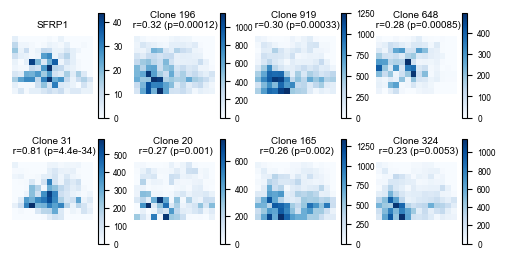

In [29]:
clusters,counts = np.unique(region['bc_cluster'],return_counts=True)

# get the clusters with at least 10 cells
clusters = clusters[counts>=10]
# drop na
clusters = clusters[~np.isnan(clusters)]

clusters_to_skip = [132,41,]


clusters = clusters[np.argsort(cluster_correlation)[::-1]]
correlations = np.sort(cluster_correlation)[::-1]



plt.figure(figsize=(4*1.5,2*1.5))
plt.subplot(2,4,1)
points_of_interest = sg_obj.points_gdf[sg_obj.points_gdf['name']=='SFRP1']

bin_size = 514 # visium bin size
# bin_size = 74.77 # visiumHD bin size

n_x_bins = int((xmax-xmin)/bin_size)+1
n_y_bins = int((ymax-ymin)/bin_size)+1

H_gene, xedges, yedges = np.histogram2d(x=points_of_interest.x,y=points_of_interest.y,bins=[[xmin+bin_size*i for i in range(n_x_bins)],
                                                                   [ymin+bin_size*i for i in range(n_y_bins)]],
                                                                   range=[[xmin,xmin+bin_size*n_x_bins],[ymin,ymin+bin_size*n_x_bins]])

# Plot the 2D histogram
plt.imshow(H_gene.swapaxes(0,1), interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],cmap='Blues')
plt.colorbar()
# plt.gca().set_aspect('equal')
# plt.gca().set_aspect(abs((xedges[-1]-xedges[0])/(yedges[0]-yedges[-1]))*1)
plt.gca().invert_yaxis()
plt.title('SFRP1')

# plt.gca().set_xticks(xedges)
# plt.gca().set_yticks(yedges)
# plt.gca().tick_params(which='major', color='k')
# plt.gca().grid(True, which='major',zorder=100,color='k',lw=0.5)

# plt.xticks()
plt.axis('off')
# plt.show()

counter = 0
subplot_list = [5,2,3,4,6,7,8]

for c,cluster in enumerate(clusters):

    if cluster not in clusters_to_skip:
        # continue

        if correlations[c] < 0.22:
            continue
        
        c = counter

        this_name = region[region['bc_cluster']==cluster]['bc_cluster_bc_names'].values[0]
        cluster_barcodes = this_name.split('-')

        points_of_interest = sg_obj.points_gdf[sg_obj.points_gdf['name'].isin(cluster_barcodes)]

        H, xedges, yedges = np.histogram2d(x=points_of_interest.x,y=points_of_interest.y,bins=[[xmin+bin_size*i for i in range(int((xmax-xmin)/bin_size)+1)],
                                                                    [ymin+bin_size*i for i in range(int((ymax-ymin)/bin_size)+1)]],
                                                                    range=[[xmin,xmax],[ymin,ymax]])
        
        print(cluster)
        print(scipy.stats.pearsonr(H_gene.flatten(),H.flatten()))

        plt.subplot(2,4,subplot_list[c])

        # Plot the 2D histogram
        plt.imshow(H.swapaxes(0,1), interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],cmap='Blues')
        plt.colorbar()
        # plt.gca().set_aspect('equal')
        # plt.gca().set_aspect(abs((xedges[-1]-xedges[0])/(yedges[0]-yedges[-1]))*1)
        plt.gca().invert_yaxis()
        plt.title(f'Clone {int(cluster)} \n r={scipy.stats.pearsonr(H_gene.flatten(),H.flatten())[0]:.2f} (p={scipy.stats.pearsonr(H_gene.flatten(),H.flatten())[1]:.2g})')
        plt.axis('off')

        counter += 1

plt.savefig('../graphs/cluster_31_SFRP1_spots_visiumcomparision_colorbar.pdf',bbox_inches='tight',transparent=True)
# plt.savefig('plots/figures/forpaper_cluster_31_SFRP1_spots_visiumHDcomparision.pdf',bbox_inches='tight')

31.0
PearsonRResult(statistic=0.8120330817082311, pvalue=4.417051550524284e-34)
132.0
PearsonRResult(statistic=0.7712395469156123, pvalue=7.419166634013848e-29)
41.0
PearsonRResult(statistic=0.4398271720882451, pvalue=5.413369547762816e-08)
196.0
PearsonRResult(statistic=0.31950221426542025, pvalue=0.00011915248357490022)
919.0
PearsonRResult(statistic=0.29915457669001005, pvalue=0.00033005068990201234)
648.0
PearsonRResult(statistic=0.2788738106428938, pvalue=0.0008482713384591332)
20.0
PearsonRResult(statistic=0.2742843912152619, pvalue=0.001040250614946966)
165.0
PearsonRResult(statistic=0.2587564710911205, pvalue=0.0020222229161292195)


ValueError: num must be 1 <= num <= 8, not 9

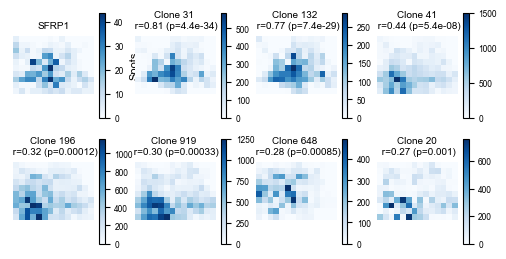

In [30]:
clusters,counts = np.unique(region['bc_cluster'],return_counts=True)


# get the clusters with at least 10 cells
clusters = clusters[counts>=10]
# drop na
clusters = clusters[~np.isnan(clusters)]

clusters = clusters[np.argsort(cluster_correlation)[::-1]]
correlations = np.sort(cluster_correlation)[::-1]

plt.figure(figsize=(4*1.5,2*1.5))
plt.subplot(2,4,1)
points_of_interest = sg_obj.points_gdf[sg_obj.points_gdf['name']=='SFRP1']

bin_size = 514 # visium bin size
# bin_size = 74.77 # visiumHD bin size

n_x_bins = int((xmax-xmin)/bin_size)+1
n_y_bins = int((ymax-ymin)/bin_size)+1

H_gene, xedges, yedges = np.histogram2d(x=points_of_interest.x,y=points_of_interest.y,bins=[[xmin+bin_size*i for i in range(n_x_bins)],
                                                                   [ymin+bin_size*i for i in range(n_y_bins)]],
                                                                   range=[[xmin,xmin+bin_size*n_x_bins],[ymin,ymin+bin_size*n_x_bins]])

# Plot the 2D histogram
plt.imshow(H_gene.swapaxes(0,1), interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],cmap='Blues')
plt.colorbar(label='Spots')
# plt.gca().set_aspect('equal')
# plt.gca().set_aspect(abs((xedges[-1]-xedges[0])/(yedges[0]-yedges[-1]))*1)
plt.gca().invert_yaxis()
plt.title('SFRP1')

# plt.gca().set_xticks(xedges)
# plt.gca().set_yticks(yedges)
# plt.gca().tick_params(which='major', color='k')
# plt.gca().grid(True, which='major',zorder=100,color='k',lw=0.5)

# plt.xticks()
plt.axis('off')
# plt.show()

counter = 0

subplot_list = [2,3,4,6,7,8,10,11,12]

for c,cluster in enumerate(clusters):

    if correlations[c] < 0.25:
        continue
    
    c = counter

    this_name = region[region['bc_cluster']==cluster]['bc_cluster_bc_names'].values[0]
    cluster_barcodes = this_name.split('-')

    points_of_interest = sg_obj.points_gdf[sg_obj.points_gdf['name'].isin(cluster_barcodes)]

    H, xedges, yedges = np.histogram2d(x=points_of_interest.x,y=points_of_interest.y,bins=[[xmin+bin_size*i for i in range(int((xmax-xmin)/bin_size)+1)],
                                                                   [ymin+bin_size*i for i in range(int((ymax-ymin)/bin_size)+1)]],
                                                                   range=[[xmin,xmax],[ymin,ymax]])
    
    print(cluster)
    print(scipy.stats.pearsonr(H_gene.flatten(),H.flatten()))

    plt.subplot(2,4,c+2)

    # Plot the 2D histogram
    plt.imshow(H.swapaxes(0,1), interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],cmap='Blues')
    plt.colorbar()
    # plt.gca().set_aspect('equal')
    # plt.gca().set_aspect(abs((xedges[-1]-xedges[0])/(yedges[0]-yedges[-1]))*1)
    plt.gca().invert_yaxis()
    plt.title(f'Clone {int(cluster)} \n r={scipy.stats.pearsonr(H_gene.flatten(),H.flatten())[0]:.2f} (p={scipy.stats.pearsonr(H_gene.flatten(),H.flatten())[1]:.2g})')
    plt.axis('off')

    counter += 1

# plt.savefig('../graphs/cluster_31_SFRP1_spots_visiumcomparision.pdf',bbox_inches='tight')
# plt.savefig('plots/figures/forpaper_cluster_31_SFRP1_spots_visiumHDcomparision.pdf',bbox_inches='tight')

In [ ]:
confident_clusters_gdf.groupby(by='bc_cluster')['IFIT2'].mean().sort_values(ascending=False).head(10)

bc_cluster
756.0     0.593750
527.0     0.578947
722.0     0.500000
15.0      0.477157
490.0     0.454545
1303.0    0.322581
681.0     0.300000
266.0     0.291209
93.0      0.263158
72.0      0.261494
Name: IFIT2, dtype: float64

In [ ]:
# confident_clusters_gdf.groupby(by='bc_cluster')['IFIT2']


confident_clusters_gdf[confident_clusters_gdf['IFIT2'] > 1].groupby(by='bc_cluster')['IFIT2'].count().sort_values(ascending=False).head(10)

bc_cluster
72.0      38
372.0     17
15.0       9
756.0      5
266.0      5
138.0      4
62.0       3
1303.0     3
2051.0     3
238.0      2
Name: IFIT2, dtype: int64

In [ ]:
adata_genes.obs['bc_cluster']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
67197   NaN
67198   NaN
67199   NaN
67200   NaN
67201   NaN
Name: bc_cluster, Length: 67202, dtype: float64

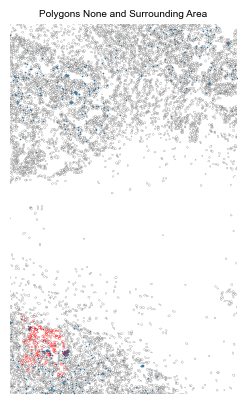

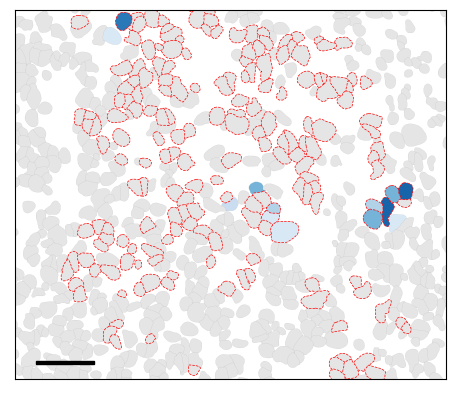

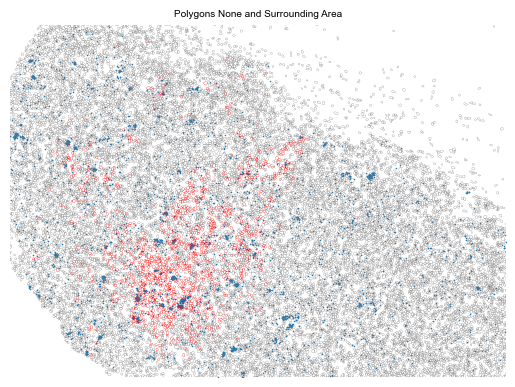

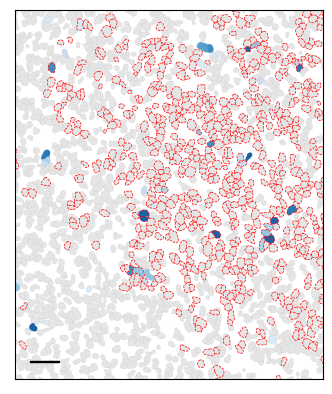

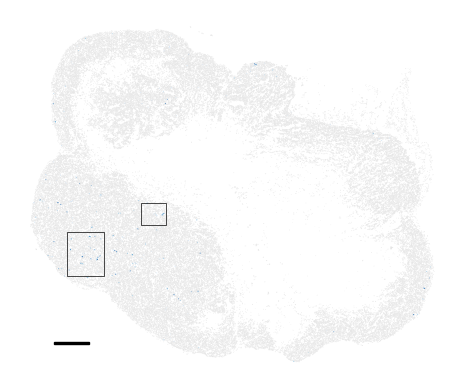

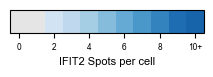

In [ ]:
gene_of_interest = 'IFIT2'
clusters_of_interest = [15,72]
# clusters_of_interest = [72,372,15,756]

custom_lims = {15:[17000,20500,25000,28000],
               
               72:[7000,12000,29000,35000],}

cluster_boxes = {}

for cluster_of_interest in clusters_of_interest:

    # get the cells associated with the manual cluster
    cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster'].isin([cluster_of_interest])].obs['cell_id'].values)
    central_ix = int(len(cluster_cells)/2) 
    cell_id = cluster_cells[central_ix] # get the cell in the middle of the cluster, we'll center on that one

    region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=-0.5,id_field='cell_id')

    fig,ax = plt.subplots()
    tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=[gene_of_interest],central_polygon_ix=central_ix,
                                color_map={gene_of_interest:(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)},
                                #    id_field='cell_id',
                                annotate=False,image_scale=0.1,
                                focal_outline_color='r',other_outline_color='gray',
                                interior_marker='.',single_mode=False,lw=0.2,
                                exterior_marker='.',marker_size=5,ax=ax)

    ymin,ymax = plt.ylim()
    xmin,xmax = plt.xlim()

    plt.axis('off')
    # plt.title()
    plt.gca().invert_yaxis()

    ### PLOT THE ZOOMED IN IMAGE     
    fig,ax = plt.subplots()

    vmin = 2
    vmax = 10

    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

    xmin = custom_lims[cluster_of_interest][0]
    xmax = custom_lims[cluster_of_interest][1]
    ymin = custom_lims[cluster_of_interest][2]
    ymax = custom_lims[cluster_of_interest][3]

    bbox = box(xmin,ymin,xmax,ymax)
    # bbox = box(custom_lims[cluster_of_interest][0],custom_lims[cluster_of_interest][2],custom_lims[cluster_of_interest][1],custom_lims[cluster_of_interest][3])
    other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

    merged_gdf_other = merged_gdf[merged_gdf['cell_id'].isin(other_clusters['cell_id'].values)]

    cmap = matplotlib.cm.get_cmap('Blues').copy()
    cmap = cmap(np.linspace(0.15, 0.8, 256))

    cmap = matplotlib.colors.ListedColormap(cmap)
    cmap.set_under('#e5e5e5') # set low values to gray

    merged_gdf_other.plot(column=gene_of_interest, cmap=cmap, legend=False, ax=ax,
                    vmin=vmin,vmax=vmax,edgecolor='gray',linewidth=0.05)

    this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest]
    # this_cluster = adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])]

    merged_gdf_focal = merged_gdf[merged_gdf['cell_id'].isin(this_cluster.obs['cell_id'].values)]

    # print(merged_gdf_focal.shape)
    merged_gdf_focal.plot(column=gene_of_interest, cmap=cmap, legend=False, ax=ax,
                    vmin=vmin,vmax=vmax,edgecolor='r',linewidth=0.5,linestyle='--')

    # Add the patch to the Axes
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)

    xmin,xmax = plt.xlim()
    ymin,ymax = plt.ylim()  

    scale_bar_length_um = 50 # 1000um scale bar
    scale_bar_length_px = int(scale_bar_length_um * 1000.0 / tools.sg_pixel_size)  # px
    scale_bar = matplotlib.patches.Rectangle((xmin+(0.05*((xmax-xmin))),ymax-(0.05*(ymax-ymin))), 
                                            scale_bar_length_px, scale_bar_length_px/20, linewidth=1, edgecolor='k', facecolor='k')
    plt.gca().add_patch(scale_bar)


    plt.gca().invert_yaxis()

    cluster_boxes[cluster_of_interest] = [xmin,xmax,ymin,ymax]

    ax.set_xticks([])
    ax.set_yticks([])
    # ax.set_facecolor('#F5F5F5')
    plt.savefig(f'../graphs/cluster_{cluster_of_interest}_{gene_of_interest}_zoom_grayed.pdf',bbox_inches='tight')


### PLOT THE FULL IMAGE WITH THE CLUSTER HIGHLIGHTED
fig,ax = plt.subplots()

merged_gdf.plot(column=gene_of_interest, cmap=cmap, legend=False,vmin=vmin,vmax=vmax,ax=ax,
                edgecolor='#d9d9d9',linewidth=0.0)

rects = {}
for cluster,cluster_box in cluster_boxes.items():
    # rectangle where magnification is
    rects[cluster] = matplotlib.patches.Rectangle((cluster_box[0], cluster_box[2]), (cluster_box[1]-cluster_box[0]), 
                                        (cluster_box[3]-cluster_box[2]), linewidth=0.5, edgecolor='k', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rects[cluster])

ax.set_facecolor('#F5F5F5')

xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()  

scale_bar_length_um = 500 # 1000um scale bar
scale_bar_length_px = int(scale_bar_length_um * 1000.0 / tools.sg_pixel_size)  # px
scale_bar = matplotlib.patches.Rectangle((xmin+(0.1*((xmax-xmin))),ymax-(0.1*(ymax-ymin))), 
                                          scale_bar_length_px, scale_bar_length_px/20, linewidth=1, edgecolor='k', facecolor='k')
plt.gca().add_patch(scale_bar)

plt.axis('off')
plt.gca().invert_yaxis()

plt.savefig(f'../graphs/{gene_of_interest}_full_grayed.pdf',bbox_inches='tight',transparent=True)
plt.savefig(f'../graphs/{gene_of_interest}_full_grayed.png',dpi=500,bbox_inches='tight',transparent=True)


### PLOT THE COLORBAR
fig,ax = plt.subplots(figsize=(2.5,0.3))
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax,clip=False)
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,boundaries=[0]+list(np.arange(1,12,1)),ticks=[0,2,4,6,8,10],
                            norm=norm,
                            orientation='horizontal')
cb1.set_label(f'{gene_of_interest} Spots per cell')

cb1.set_ticks([x+0.5 for x in [0,2,4,6,8,10]])
cb1.set_ticklabels(['0','2','4','6','8','10+'])

plt.savefig(f'../graphs/{gene_of_interest}_colorbar_grayed.pdf',bbox_inches='tight',transparent=True)



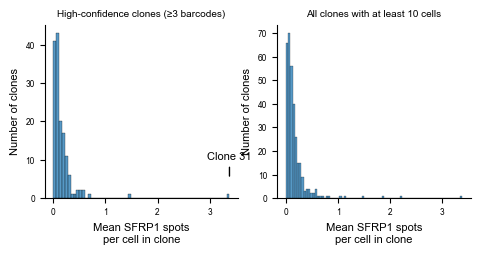

In [ ]:
### Overall distrubtion of average SFRP1 expression per clone 

plt.figure(figsize=(5.5,2.25))
# clusters_of_interest = clone_lims[roi_of_interest].keys() # get the clusters of interest for the roi of interest

plt.subplot(1,2,1)

sns.histplot(confident_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].mean())
plt.xlabel('Mean SFRP1 spots\nper cell in clone')
plt.ylabel('Number of clones')
plt.title('High-confidence clones (≥3 barcodes)')

for cluster_of_interest in [31]:

    cluster_barcode_names = large_clusters_gdf[large_clusters_gdf['bc_cluster'] == cluster_of_interest]['bc_cluster_bc_names'].values[0]
    # annotate the cluster of interest on the histogram
    plt.annotate(f'Clone {cluster_of_interest}',
                    xy=(large_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].mean()[cluster_of_interest], 5),
                    xytext=(large_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].mean()[cluster_of_interest], 10),
                    arrowprops=dict(arrowstyle='-',facecolor='black',),ha='center',
                    fontsize=8)

plt.subplot(1,2,2)
# plt.figure(figsize=(2.25,2.25))
# clusters_of_interest = clone_lims[roi_of_interest].keys() # get the clusters of interest for the roi of interest

sns.histplot(large_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].mean())
plt.xlabel('Mean SFRP1 spots\nper cell in clone')
plt.ylabel('Number of clones')
plt.title('All clones with at least 10 cells')



                 

    # plt.axvline(large_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].mean()[cluster_of_interest], color='red', linestyle='--')

sns.despine()
# plt.savefig(f'../graphs/in_vivo_SFRP1_mean_spots_per_cluster_large_labeled.pdf',bbox_inches='tight',pad_inches=0,dpi=300)

In [ ]:
confident_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].mean().sort_values(ascending=False).head(10)

bc_cluster
31.0      3.379310
490.0     1.454545
41.0      0.692308
1136.0    0.571429
391.0     0.557377
253.0     0.529412
51.0      0.500000
909.0     0.454545
1298.0    0.444444
49.0      0.404255
Name: SFRP1, dtype: float64

In [ ]:
large_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].mean().sort_values(ascending=False).head(10)

bc_cluster
31.0      3.379310
132.0     2.181818
1672.0    1.857143
490.0     1.454545
1106.0    1.151515
265.0     1.055556
64.0      0.839623
954.0     0.800000
41.0      0.692308
120.0     0.646192
Name: SFRP1, dtype: float64

In [ ]:
this_cluster = large_clusters_gdf[large_clusters_gdf['bc_cluster']==265]

print(this_cluster['center_x'].min(),this_cluster['center_x'].max())
print(this_cluster['center_y'].min(),this_cluster['center_y'].max())

19814.133892724552 28469.2474386939
27262.813302309387 40791.12597381949


In [ ]:
large_clusters_gdf[large_clusters_gdf['bc_cluster']==265]

,nucleus,nucleus_dilated,nucleus_centroid,center_x,center_y,area,object_id,cell_id,AKT1,AXL,...,bc_093,bc_094,bc_095,bc_096,bc_cluster,bc_cluster_bc_names,bc_cluster_found_bcs,bc_cluster_n_bcs,called_barcodes,n_called_barcodes
30381,"POLYGON ((21483.000 27213.000, 21497.000 27215...","POLYGON ((21386.740 27265.492, 21387.385 27267...",POINT (21484.598 27262.813),21484.598208,27262.813302,15095.521045,37341,37341,9.0,0.0,...,0.0,0.0,0.0,0.0,265.0,bc_073,['bc_073'],1.0,"['bc_073', 'bc_081']",2.0
30525,"POLYGON ((21445.000 27289.000, 21459.000 27292...","POLYGON ((21435.715 27285.286, 21435.594 27285...",POINT (21443.473 27316.582),21443.473047,27316.581965,5815.460840,37471,37471,2.0,0.0,...,0.0,0.0,0.0,0.0,265.0,bc_073,['bc_073'],1.0,['bc_073'],1.0
31798,"POLYGON ((19858.000 27969.000, 19865.000 27969...","POLYGON ((19787.008 27978.848, 19785.051 27980...",POINT (19814.134 28036.886),19814.133893,28036.886425,25890.939890,38617,38617,12.0,0.0,...,0.0,0.0,0.0,0.0,265.0,bc_073,['bc_073'],1.0,"['bc_025', 'bc_073', 'bc_079', 'bc_083']",4.0
32345,"POLYGON ((22228.000 28255.000, 22262.000 28258...","POLYGON ((22220.106 28248.861, 22213.106 28257...",POINT (22243.990 28304.318),22243.990062,28304.318471,8837.369804,39109,39109,4.0,0.0,...,0.0,0.0,0.0,0.0,265.0,bc_073,['bc_073'],1.0,"['bc_025', 'bc_073']",2.0
35942,"POLYGON ((19955.000 30061.000, 19971.000 30061...","POLYGON ((19951.968 30051.471, 19929.968 30058...",POINT (19955.485 30080.121),19955.484832,30080.120889,3779.900554,42346,42346,0.0,0.0,...,0.0,0.0,0.0,0.0,265.0,bc_073,['bc_073'],1.0,['bc_073'],1.0
48202,"POLYGON ((24655.000 36545.000, 24677.000 36546...","POLYGON ((24634.854 36658.022, 24635.181 36658...",POINT (24667.565 36601.329),24667.565134,36601.329013,12695.617624,53380,53380,3.0,0.0,...,0.0,0.0,0.0,0.0,265.0,bc_073,['bc_073'],1.0,"['bc_033', 'bc_073']",2.0
48244,"POLYGON ((23849.000 36568.000, 23857.000 36576...","POLYGON ((23839.156 36569.758, 23843.926 36596...",POINT (23895.499 36635.289),23895.498714,36635.288667,11354.753957,53418,53418,2.0,0.0,...,0.0,0.0,0.0,0.0,265.0,bc_073,['bc_073'],1.0,"['bc_067', 'bc_073']",2.0
48282,"POLYGON ((25256.000 36584.000, 25269.000 36584...","POLYGON ((25253.905 36574.222, 25239.905 36577...",POINT (25259.268 36652.620),25259.267534,36652.619569,18896.600011,53452,53452,6.0,0.0,...,0.0,0.0,0.0,0.0,265.0,bc_073,['bc_073'],1.0,"['bc_028', 'bc_041', 'bc_066', 'bc_073']",4.0
48340,"POLYGON ((24838.000 36616.000, 24849.000 36617...","POLYGON ((24833.809 36606.920, 24820.809 36612...",POINT (24871.838 36681.248),24871.838058,36681.248196,13111.754040,53504,53504,2.0,0.0,...,0.0,0.0,0.0,0.0,265.0,bc_073,['bc_073'],1.0,"['bc_049', 'bc_073']",2.0
48361,"POLYGON ((23833.000 36624.000, 23847.000 36624...","POLYGON ((23830.324 36614.365, 23812.324 36619...",POINT (23834.190 36678.661),23834.189657,36678.661158,11263.914227,53523,53523,4.0,0.0,...,0.0,0.0,0.0,0.0,265.0,bc_073,['bc_073'],1.0,"['bc_073', 'bc_076', 'bc_092']",3.0


In [ ]:
large_clusters_gdf[large_clusters_gdf['bc_cluster']==132]

,nucleus,nucleus_dilated,nucleus_centroid,center_x,center_y,area,object_id,cell_id,AKT1,AXL,...,bc_093,bc_094,bc_095,bc_096,bc_cluster,bc_cluster_bc_names,bc_cluster_found_bcs,bc_cluster_n_bcs,called_barcodes,n_called_barcodes
22168,"POLYGON ((13926.000 22671.000, 13928.000 22671...","POLYGON ((13923.575 22661.299, 13907.575 22665...",POINT (13931.427 22710.191),13931.427057,22710.191215,7362.021655,29950,29950,0.0,0.0,...,0.0,0.0,0.0,0.0,132.0,bc_040-bc_092,"['bc_040', 'bc_092']",2.0,"['bc_040', 'bc_092']",2.0
22462,"POLYGON ((14522.000 22828.000, 14541.000 22830...","POLYGON ((14519.127 22818.422, 14509.127 22821...",POINT (14550.955 22870.725),14550.955171,22870.725108,8901.774451,30213,30213,1.0,0.0,...,0.0,0.0,0.0,0.0,132.0,bc_040-bc_092,"['bc_040', 'bc_092']",2.0,"['bc_040', 'bc_066', 'bc_092']",3.0
22863,"POLYGON ((13065.000 23044.000, 13070.000 23044...","POLYGON ((13063.039 23034.194, 13033.039 23040...",POINT (13043.219 23124.112),13043.219100,23124.111510,15448.254965,30575,30575,2.0,0.0,...,2.0,3.0,0.0,0.0,132.0,bc_040-bc_092,"['bc_040', 'bc_092']",2.0,"['bc_040', 'bc_052', 'bc_092', 'bc_094']",4.0
23187,"POLYGON ((13285.000 23225.000, 13300.000 23230...","POLYGON ((13275.578 23221.650, 13259.973 23265...",POINT (13289.031 23286.101),13289.030970,23286.100842,9834.540001,30867,30867,3.0,0.0,...,0.0,0.0,0.0,0.0,132.0,bc_040-bc_092,"['bc_040', 'bc_092']",2.0,"['bc_016', 'bc_040', 'bc_052', 'bc_067', 'bc_0...",5.0
23794,"POLYGON ((13225.000 23581.000, 13227.000 23581...","POLYGON ((13222.017 23571.455, 13206.017 23576...",POINT (13219.228 23676.878),13219.228460,23676.878370,15316.869331,31412,31412,0.0,0.0,...,6.0,0.0,0.0,0.0,132.0,bc_040-bc_092,"['bc_040', 'bc_092']",2.0,"['bc_004', 'bc_031', 'bc_040', 'bc_041', 'bc_0...",8.0
23856,"POLYGON ((13115.000 23608.000, 13130.000 23608...","POLYGON ((13113.469 23598.118, 13042.469 23609...",POINT (13112.549 23650.370),13112.549322,23650.370142,13556.172659,31469,31469,1.0,0.0,...,0.0,0.0,0.0,0.0,132.0,bc_040-bc_092,"['bc_040', 'bc_092']",2.0,"['bc_031', 'bc_040', 'bc_052', 'bc_066', 'bc_0...",5.0
24778,"POLYGON ((11518.000 24105.000, 11545.000 24107...","POLYGON ((11515.991 24095.204, 11478.605 24102...",POINT (11503.136 24154.390),11503.136308,24154.389861,15625.749432,32299,32299,11.0,1.0,...,4.0,0.0,0.0,0.0,132.0,bc_040-bc_092,"['bc_040', 'bc_092']",2.0,"['bc_024', 'bc_031', 'bc_040', 'bc_048', 'bc_0...",6.0
24784,"POLYGON ((10878.000 24107.000, 10902.000 24108...","POLYGON ((10876.953 24097.055, 10857.953 24099...",POINT (10873.920 24146.474),10873.920271,24146.474483,10808.943689,32303,32303,3.0,0.0,...,0.0,0.0,0.0,0.0,132.0,bc_040-bc_092,"['bc_040', 'bc_092']",2.0,"['bc_040', 'bc_052', 'bc_092']",3.0
24889,"POLYGON ((12440.000 24179.000, 12451.000 24179...","POLYGON ((12420.149 24228.276, 12420.136 24228...",POINT (12463.510 24222.805),12463.509673,24222.805188,7185.127247,32399,32399,2.0,0.0,...,1.0,0.0,0.0,0.0,132.0,bc_040-bc_092,"['bc_040', 'bc_092']",2.0,"['bc_040', 'bc_092']",2.0
25184,"POLYGON ((15998.000 24329.000, 16001.000 24332...","POLYGON ((15988.272 24326.684, 15983.272 24347...",POINT (16015.360 24356.142),16015.359616,24356.142411,4285.264949,32664,32664,0.0,0.0,...,2.0,0.0,0.0,0.0,132.0,bc_040-bc_092,"['bc_040', 'bc_092']",2.0,['bc_040'],1.0


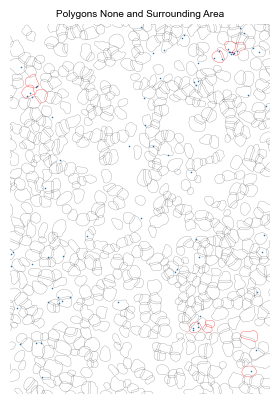

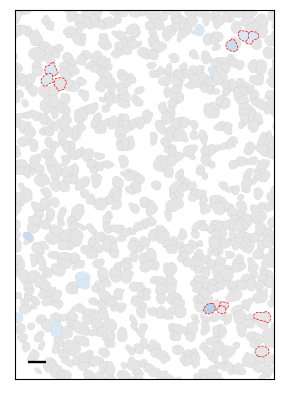

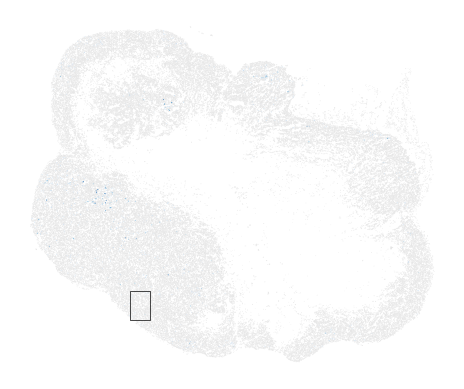

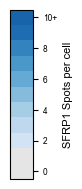

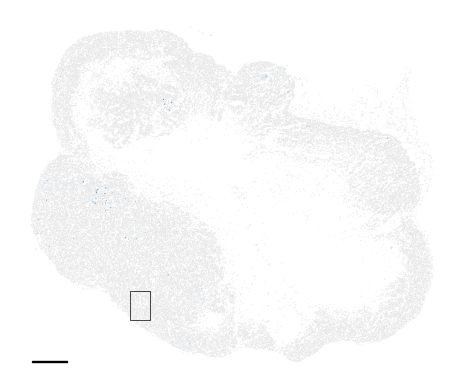

In [ ]:
gene_of_interest = 'SFRP1'
# clusters_of_interest = confident_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].mean().sort_values(ascending=False).head(10)['bc_cluster']
# clusters_of_interest = confident_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].mean().sort_values(ascending=False).index[:10]
# clusters_of_interest = large_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].mean().sort_values(ascending=False).index[:5]

# clusters_of_interest = clone_lims[roi_of_interest].keys() # get the clusters of interest for the roi of interest
clusters_of_interest = [490]

other_clone_lims = {490:[15500,18300,37000, 41000]}
# other_clone_lims = {132:[10873.920271120118,16015.359616284512,22710.19121504304,26151.85168545924]}
# other_clone_lims = {1672:[20625.46876620817,27140.381312408117,28766.82766148209,37470.26597757372]}
# other_clone_lims = {265:[19814.133892724552,28469.2474386939,27262.813302309387,40791.12597381949]}
# 19814.133892724552 28469.2474386939
# 27262.813302309387 40791.12597381949
# 20625.46876620817 27140.381312408117
# 28766.82766148209 37470.26597757372
# other_clone_lims = {1106:[13029.419516327787,18608.145808444653,8814.098496950957,15197.686241301866]}
# other_clone_lims = {132:[10873.920271120118,16015.359616284512,22710.19121504304,26151.85168545924]}

# large_clusters_gdf[large_clusters_gdf['bc_cluster'] == 862][['SFRP1','bc_cluster','bc_cluster_bc_names']]

for cluster_of_interest in clusters_of_interest:

  # get the cells associated with the manual cluster
  # cluster_cells = list(confident_clusters.obs[confident_clusters.obs['bc_cluster'].isin([cluster_of_interest])]['object_id'].values)
  cluster_cells = list(large_clusters_gdf[large_clusters_gdf['bc_cluster'].isin([cluster_of_interest])]['cell_id'].values)
  # cluster_cells = [int(x) for x in cluster_cells]
  central_ix = int(len(cluster_cells)/2) 
  cell_id = cluster_cells[central_ix] # get the cell in the middle of the cluster, we'll center on that one

  # region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=1,id_field='cell_id')

  fig = plt.figure()
  ax = plt.gca()
  tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=['SFRP1'],central_polygon_ix=central_ix,
                              color_map={'SFRP1':(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)},
                                #  id_field='object_id',
                                # id_field='cell_id',
                              annotate=False,image_scale=0.1,
                              focal_outline_color='r',other_outline_color='gray',
                              interior_marker='.',single_mode=False,lw=0.2,
                              exterior_marker='.',marker_size=5,ax=ax)


  # ymin,ymax = plt.ylim()
  # xmin,xmax = plt.xlim()

  xmin,xmax,ymin,ymax = other_clone_lims[cluster_of_interest]

  plt.axis('off')
  # plt.title()
  plt.gca().invert_yaxis()

  ### PLOT THE ZOOMED IN IMAGE     
  # fig,ax = plt.subplots()
  fig = plt.figure()
  ax = plt.gca()

  vmin = 2
  vmax = 10

  norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

  bbox = box(xmin,ymin,xmax,ymax)
  other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

  merged_gdf_other = merged_gdf[merged_gdf['cell_id'].isin(other_clusters['cell_id'].values)]

  cmap = matplotlib.cm.get_cmap('Blues').copy()
  cmap = cmap(np.linspace(0.15, 0.8, 256))

  cmap = matplotlib.colors.ListedColormap(cmap)
  cmap.set_under('#e5e5e5') # set low values to gray

  merged_gdf_other.plot(column=gene_of_interest, cmap=cmap, legend=False, ax=ax,
                  vmin=vmin,vmax=vmax,edgecolor='gray',linewidth=0.05)

  this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest]
  # this_cluster = adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])]

  merged_gdf_focal = merged_gdf[merged_gdf['cell_id'].isin(this_cluster.obs['cell_id'].values)]

  # print(merged_gdf_focal.shape)
  merged_gdf_focal.plot(column=gene_of_interest, cmap=cmap, legend=False, ax=ax,
                  vmin=vmin,vmax=vmax,edgecolor='r',linewidth=0.5,linestyle='--')
    # merged_gdf_focal.plot(column=gene_of_interest, cmap=cmap, legend=False, ax=ax,
    #               vmin=vmin,vmax=vmax,edgecolor='r',linewidth=0.5,linestyle='--')

  # Add the patch to the Axes
  plt.xlim(xmin,xmax)
  plt.ylim(ymin,ymax)
  plt.gca().invert_yaxis()

  ax.set_xticks([])
  ax.set_yticks([])

  scale_bar_length_um = 20 # 100um scale bar
  scale_bar_length_px = int(scale_bar_length_um * 1000.0 / tools.sg_pixel_size)  # px
  scale_bar = matplotlib.patches.Rectangle((xmin+(0.05*((xmax-xmin))),ymax-(0.05*(ymax-ymin))), 
                                            scale_bar_length_px, scale_bar_length_px/20, linewidth=1, edgecolor='k', facecolor='k')
  plt.gca().add_patch(scale_bar)
  # ax.set_facecolor('#F5F5F5')
  # plt.savefig(f'../graphs/other_rois/{roi_of_interest}/cluster_{cluster_of_interest}_SFRP1_zoom_grayed.pdf',pad_inches=0,bbox_inches='tight')


  ### PLOT THE FULL IMAGE WITH THE CLUSTER HIGHLIGHTED
  fig = plt.figure()
  ax = plt.gca()

  merged_gdf.plot(column=gene_of_interest, cmap=cmap, legend=False,vmin=vmin,vmax=vmax,ax=ax,
                  edgecolor='#d9d9d9',linewidth=0.0)

  # rectangle where magnification is
  rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=0.5, edgecolor='k', facecolor='none')
  # Add the patch to the Axes
  ax.add_patch(rect)

  ax.set_facecolor('#F5F5F5')
  plt.axis('off')
  plt.gca().invert_yaxis()

  # scale_bar_length_um = 100 # 100um scale bar
  # scale_bar_length_px = int(scale_bar_length_um * 1000.0 / tools.sg_pixel_size)  # px
  # scale_bar = matplotlib.patches.Rectangle((xmin+(0.1*((xmax-xmin))),ymax-(0.1*(ymax-ymin))), 
  #                                           scale_bar_length_px, scale_bar_length_px/20, linewidth=1, edgecolor='k', facecolor='k')
  # plt.gca().add_patch(scale_bar)

  # plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_full_grayed.pdf',bbox_inches='tight',transparent=True)
  # plt.savefig(f'../graphs/other_rois/{roi_of_interest}/cluster_{cluster_of_interest}_SFRP1_full_grayed.png',dpi=500,bbox_inches='tight',pad_inches=0,transparent=True)



### PLOT THE COLORBAR
# fig,ax = plt.subplots(figsize=(0.3,2.5))
# fig = plt.figure(figsize=(0.3,2.5))
fig = plt.figure(figsize=(0.3,2.2))
ax = plt.gca()
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax,clip=False)
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,boundaries=[0]+list(np.arange(1,12,1)),ticks=[0,2,4,6,8,10],
                            norm=norm,
                            orientation='vertical')
cb1.set_label('SFRP1 Spots per cell')

cb1.set_ticks([x+0.5 for x in [0,2,4,6,8,10]])
cb1.set_ticklabels(['0','2','4','6','8','10+'])

# plt.savefig(f'../graphs/other_rois/{roi_of_interest}/SFRP1_colorbar_grayed.pdf',bbox_inches='tight',pad_inches=0,transparent=True)

fig = plt.figure()
ax = plt.gca()

merged_gdf.plot(column=gene_of_interest, cmap=cmap, legend=False,vmin=vmin,vmax=vmax,ax=ax,
                edgecolor='#d9d9d9',linewidth=0.0)
xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()  

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)


for cluster_of_interest in clusters_of_interest:

  xmin,xmax,ymin,ymax = other_clone_lims[cluster_of_interest]
  # rectangle where magnification is
  rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=0.5, edgecolor='k', facecolor='none')
  # Add the patch to the Axes
  ax.add_patch(rect)

xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()  

scale_bar_length_um = 500 # 1000um scale bar
scale_bar_length_px = int(scale_bar_length_um * 1000.0 / tools.sg_pixel_size)  # px
scale_bar = matplotlib.patches.Rectangle((xmin+(0.05*((xmax-xmin))),ymax-(0.05*(ymax-ymin))), 
                                          scale_bar_length_px, scale_bar_length_px/20, linewidth=1, edgecolor='k', facecolor='k')
plt.gca().add_patch(scale_bar)

ax.set_facecolor('#F5F5F5')
plt.axis('off')
plt.gca().invert_yaxis()
# plt.savefig(f'../graphs/other_rois/{roi_of_interest}/cluster_{cluster_of_interest}_SFRP1_full_grayed_allFeaturedClones.png',dpi=500,bbox_inches='tight',pad_inches=0,transparent=True)



